# Structured Generation

Using LLMs, we often need to use regex to parse the output of the LLM, like this one:

In [1]:
import re

answer = """The first 10 digits of pi (π) are as follows:

3.1415926535
"""

regex = r"([0-9]+)?\.[0-9]+"
print(re.search(regex, answer))

<re.Match object; span=(47, 59), match='3.1415926535'>


In this practical, we will directly couple the regex with the LLM so that the output has exactly the right format!

We follow the ideas of [Efficient Guided Generation for Large Language Models](https://arxiv.org/abs/2307.09702) by Brandon T. Willard, Rémi Louf.

Regular expressions are a language that allows us to express patterns in text, and libraries can use a regex processor to find (sub)strings that match a given pattern. And if we’re able to match patterns, we’re also able to generate text that matches this pattern.

The naive regex-guided generation process that loops over the entire vocabulary to find matches at each step:
1. Start the generation with an empty prefix (the empty string).
2. Concatenate every token of the vocabulary to the prefix. This gives you the set of all possible completions.
3. For every possible completion use regex’s partial match feature to determine whether it can lead to a completion that matches the regex pattern. If that’s not the case, mask the token by setting its logit value to −∞.
4. Use the masked logits to sample a new token.
5. Concatenate the new token to the prefix and go back to (2).

To generate a string that matches the regex `[0-9]+\.[0-9]` and with a vocabulary `["a", ".", ".2", "1"]`, starting with the empty string `““`, the following diagram illustrates the process we just described:
![](https://cdn.prod.website-files.com/665725b00d910f65bec567fc/668c29d45780ee71a367c839_naive.png)

Another useful feature of regex processors is the ability to perform partial matches. A partial match is a string that matches up until its last character, thus one for which we could find completions that would have matched the pattern. This does not come with Python’s standard `re` library, but the [regex](https://github.com/mrabarnett/mrab-regex) library provides the functionality.

In [2]:
import regex as re

regex = r"([0-9]+)?\.[0-9]+"
print(re.fullmatch(regex, '.2', partial=True))

<regex.Match object; span=(0, 2), match='.2'>


In [3]:
print(re.fullmatch(regex, '1.2', partial=True))

<regex.Match object; span=(0, 3), match='1.2'>


In [4]:
print(re.fullmatch(regex, '1.2a', partial=True))

None


In [ ]:
import math
import regex as re
import numpy as np

from scipy.special import softmax

np.random.seed(12349)

logits = np.array([1., 1., 1., 1.])  # Random model with equal probabilities
vocabulary = ["a", ".", ".2", "1"]

regex = r"([0-9]+)?\.[0-9]+"

completion = ""
for _ in range(7):

    # Build the logit mask
    #
    # your code here
    #
    masked_logits = logits + mask

    # Sample the next token
    probs = softmax(masked_logits)
    next_token_id = np.random.choice(len(vocabulary), p=probs)

    completion += vocabulary[next_token_id]

print(completion)

This will work for any regex pattern supported by the regex library, and does not depend on the tokenization shenanigans that LLM researchers make the rest of us suffer through. Isn’t this lovely?

Bad news: this algorithm will explode in your face. The typical vocabulary $𝑉$ of a large language model contains roughly 50,000 (fifty thousand) tokens, which means that for each token you want to generate you will need to perform 50,000 partial matches. In a language like Python, the time spent performing partial matches will easily dominate the time it takes to generate the next token. While we’ve just solved the problem in theory, this solution is unusable in practice.

## Deterministic Finite Automaton (DFA) a kind of Finite-State Machine (FSM)

1. Start in state 0 with the full string;
2. Pop the first character of the string. If it matches any transition rule, it moves to the corresponding state. Otherwise we terminate and reject the string;
3. Iterate until the string is either rejected or you reach one of the DFA’s final (also called accept) states.

What does the DFA look like for a given regular expression? Let’s consider the regular expression than previously, `([0-9])?+\.[0-9]+`, and use the [interegular](https://github.com/MegaIng/interegular) Python library to translate it to its equivalent DFA representation:

In [5]:
import interegular

regex = r"([0-9]+)?\.[0-9]+"
fsm = interegular.parse_pattern(regex).to_fsm()

print(fsm)

  name final? . 0 1 2 3 4 5 6 7 8 9 anything_else 
--------------------------------------------------
* 0    False  2 1 1 1 1 1 1 1 1 1 1               
  1    False  2 3 3 3 3 3 3 3 3 3 3               
  2    False    4 4 4 4 4 4 4 4 4 4               
  3    False  2 3 3 3 3 3 3 3 3 3 3               
  4    True     5 5 5 5 5 5 5 5 5 5               
  5    True     5 5 5 5 5 5 5 5 5 5               



In [6]:
print(fsm.alphabet)

anything_else | 0
0-9           | 1
.             | 2


In [7]:
for (start, transitions) in fsm.map.items():
    print(start, transitions)

0 {1: 1, 2: 2}
1 {1: 3, 2: 2}
2 {1: 4}
3 {1: 3, 2: 2}
4 {1: 5}
5 {1: 5}


In [8]:
print(fsm.initial)

0


In [9]:
print(fsm.finals)

frozenset({4, 5})


In [12]:
char_2_str = ['any', ' [0-9]', ' . ']

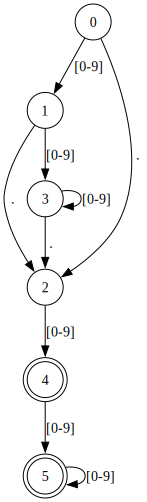

In [13]:
import graphviz
from IPython.display import display

# Define the regex pattern
regex = r"([0-9]+)?\.[0-9]+"

# Convert regex to a finite state machine (FSM)
fsm = interegular.parse_pattern(regex).to_fsm()

# Generate Graphviz DOT format representation
dot = graphviz.Digraph(format="png")

# Add states to the graph
for state in fsm.states:
    shape = "doublecircle" if state in fsm.finals else "circle"
    dot.node(str(state), shape=shape)

# Add transitions to the graph
for (start, transitions) in fsm.map.items():
    for char, end in transitions.items():
        dot.edge(str(start), str(end), label=char_2_str[char] if char is not None else "ε")

display(dot)

In [ ]:
fsm.map

First we need to figure out whether tokens in the vocabulary correspond to a valid path between states of the DFA. This is what the following function should do. If a token corresponds to a valid path, like “.2” we return the visited states. If it doesn’t, like ” The” we return None. 

In [ ]:
def partial_match(state, token):
    """Partially match the token to the DFA starting from `state`.

    We iterate over the token's symbols, and at each step transition to the 
    next state if we find a valid transition. 
    If there is a stage without a valid transision, we return None, otherwise
    we return a tuple that contains the sequence of traversed states.

    """
    
    traversed_states = (state,)

    # Iterate over the token's symbols, trying at each step to transition
    # to a new DFA state.
    #
    # your code here
    #
    
    return traversed_states

In [ ]:
token = ".21"
print(partial_match(0, token))

In [ ]:
token = ".21a"
print(partial_match(0, token))

To build a map from the DFA’s states to tokens that correspond to valid completions, we need to loop over the states of the DFA, and for each state loop through the vocabulary to check whether tokens correspond to a valid path starting from this state:

In [ ]:
from collections import defaultdict

vocabulary = ["a", ".", ".2", "1"]

# Map from the DFA states to the tokens that correspond to a valid transition
# from this state.
states_to_vocab = defaultdict(set)
#
# your code here
#

In [ ]:
states_to_vocab

The generation can now proceed as follows:

1. Start in state 0. Look for the tokens that lead to valid completions starting from 0 with `states_to_vocab[0]`.
2. Mask the logits returned by the LLM so only these tokens can be sampled;
3. Sample a new token using the logits. Look at the path that corresponds to `(state,token)`, the last state of the path corresponds to the next state of the DFA, `new_state`;
4. Look for the tokens that lead to valid completions starting from `new_state` with `states_to_vocab[new_state]`.
5. Go to (2) until the FSM is in one of its terminal states and this terminal state has no transition.

In [ ]:
np.random.seed(12349) # you should get the same result as before

logits = np.array([1., 1., 1., 1.])  # same as before

regex = r"([0-9]+)?\.[0-9]+"

completion = ""
state = fsm.initial
for _ in range(7):

    # Build the logit mask
    #
    # your code here
    #

print(completion)

To go further: [Coalescence: making LLM inference 5x faster](https://blog.dottxt.co/coalescence.html)